4. (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy и сравнить результаты построения леса по Шеннону и Gini.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

import random

import numpy as np

from sklearn import datasets
from sklearn import model_selection
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [204]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

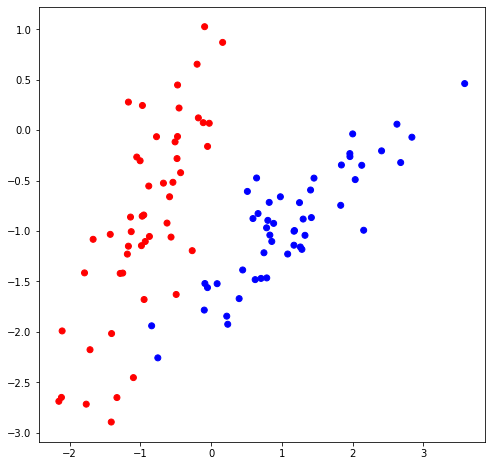

In [205]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [206]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [207]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его   
        prediction = max(classes, key=classes.get)
        return prediction

In [208]:
# p = classes[label] / len(labels)
# entropy -= p * np.log2(p)

# Расчет критерия энтропии для классификации

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entropy = 0
    for label in classes:
        p = classes[label] / len(labels) # долю объектов класса в листе
        entropy -= p * np.log2(p) # Критерий Джини
        
    return entropy

In [209]:
# p = classes[label] / len(labels)
# impurity -= p ** 2

# Расчет критерия Джини для классификации

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels) # долю объектов класса в листе
        impurity -= p ** 2 # Критерий Джини
        
    return impurity

In [210]:
# current_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)
# Расчет качества

def quality(left_labels, right_labels, current_criterion, criterion):
    
    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
#     criterion = 1 энтропия
#     criterion = 2 джини
    if criterion == 2:
        return current_criterion - p * gini(left_labels) - (1 - p) * gini(right_labels) # Функционал качества
    if criterion == 1:
        return current_criterion - p * entropy(left_labels) - (1 - p) * entropy(right_labels) # Функционал качества    

In [211]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [212]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, criterion):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    if criterion == 1:
        current_criterion = entropy(labels)
    else:
        current_criterion = gini(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    n_features = data.shape[1] # кол-во признаков
    
    for index in range(n_features): # проход по всем признакам
        t_values = [row[index] for row in data] # берем столбец/признак с соотв. индексом
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = quality(true_labels, false_labels, current_criterion=current_criterion, criterion=criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [213]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_deep, criterion, count = 0):

    quality, t, index = find_best_split(data, labels, criterion=criterion) # ищем лучшее разбиение
    print(quality, t, index)

#  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0: # критерий останова
        return Leaf(data, labels) # считаем прогноз для листьев
    
    #  прекращаем рекурсию, когда глубина дерева дерева достигла порога max_deep
    if count >= max_deep: # критерий останова
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    count += 1
    true_branch = build_tree(true_data, true_labels, max_deep = max_deep, count = count, criterion=criterion)
    false_branch = build_tree(false_data, false_labels, max_deep = max_deep, count = count, criterion=criterion)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [214]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [215]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [216]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [217]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [218]:
# Построим дерево по обучающей выборке c критерием джини
max_deep = 5
my_tree_jini = build_tree(train_data, train_labels, criterion = 2, max_deep = max_deep)
print(my_tree_jini)
display(my_tree_jini.t, my_tree_jini.true_branch , my_tree_jini.false_branch)

0.375 0.16261402870113306 0
0.07291666666666671 -1.5208896621663803 1
0.3472222222222221 -0.9478301462477035 0
0 None None
0 None None
0 None None
0 None None


0.16261402870113306

In [219]:
# Построим дерево по обучающей выборке c критерием энтропии
max_deep = 5
my_tree_entropy = build_tree(train_data, train_labels, criterion = 1, max_deep = max_deep)
print(my_tree_entropy)
display(my_tree_entropy.t, my_tree_entropy.true_branch , my_tree_entropy.false_branch)

0.6893917467430878 0.16261402870113306 0
0.2496038162042506 -1.5208896621663803 1
0.6548575458269758 -0.9478301462477035 0
0 None None
0 None None
0 None None
0 None None


0.16261402870113306

In [220]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree_entropy)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [221]:
print_tree(my_tree_jini)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [222]:
# Получим ответы для обучающей выборки 
train_answers_entropy = predict(train_data, my_tree_entropy)
train_answers_jini = predict(train_data, my_tree_jini)

In [223]:
# Получим ответы для тестовой выборки
answers_entropy = predict(test_data, my_tree_entropy)
answers_jini = predict(test_data, my_tree_jini)

In [224]:
# Точность на обучающей выборке
train_accuracy_entropy = accuracy_metric(train_labels, train_answers_entropy)
train_accuracy_jini = accuracy_metric(train_labels, train_answers_jini)

print(f'entropy: {train_accuracy_entropy}, jini: {train_accuracy_jini}')

entropy: 98.57142857142858, jini: 98.57142857142858


In [225]:
# Точность на тестовой выборке
test_accuracy_entropy = accuracy_metric(test_labels, answers_entropy)
test_accuracy_jini = accuracy_metric(test_labels, answers_jini)

print(f'entropy: {test_accuracy_entropy}, jini: {test_accuracy_jini}')

entropy: 100.0, jini: 100.0


Вывод: результаты по критериям Джини и энтропии не отличаются

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [179]:
##### сгенерируем данные, представляющие собой 100 объектов с 2-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

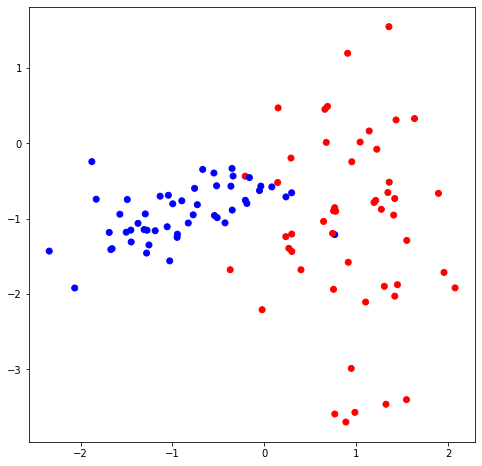

In [180]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [181]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [182]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [183]:
# класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [184]:
# класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [185]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [186]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [187]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [188]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [189]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [190]:
# функция формирования случайного леса

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [191]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [192]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [193]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [194]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [195]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [196]:
# лес из одного дерева

n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 98.571
Точность случайного леса из 1 деревьев на тестовой выборке: 86.667


(5159, 0) (5159, 1) (5159, 1)


Text(0.5, 1.0, 'Test accuracy=86.67')

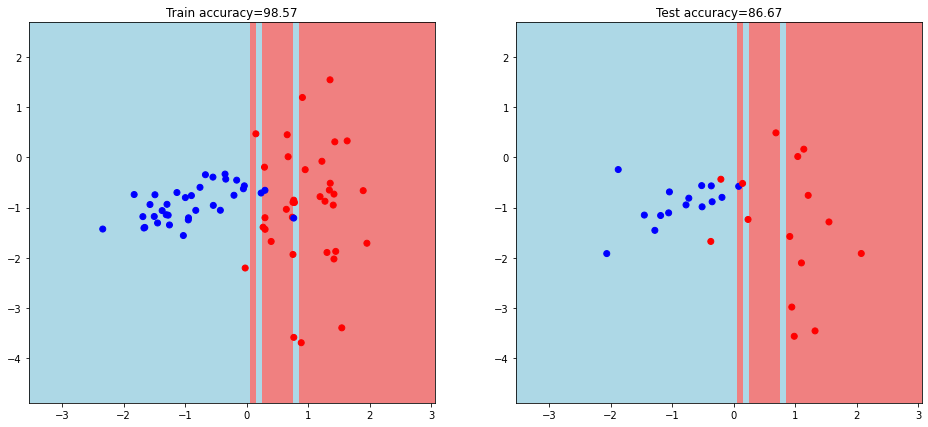

In [197]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.1, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_1,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [198]:
# лес из трех деревьев

n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 98.571
Точность случайного леса из 3 деревьев на тестовой выборке: 86.667


(5159, 0) (5159, 1) (5159, 1)


Text(0.5, 1.0, 'Test accuracy=86.67')

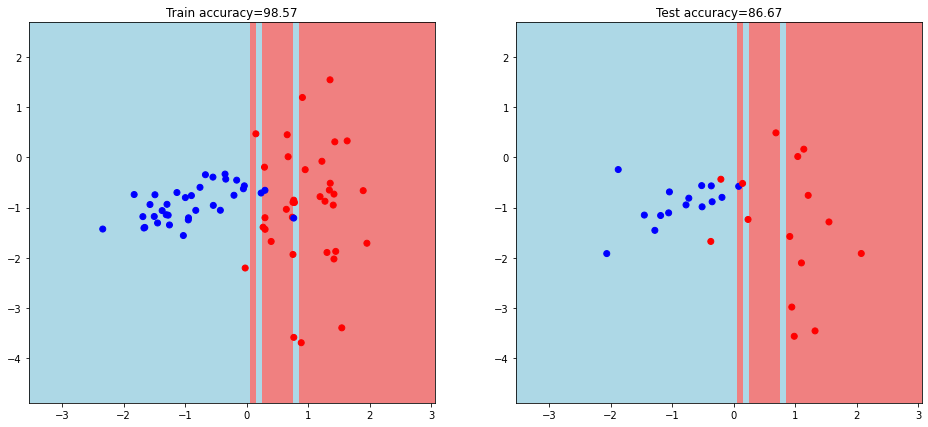

In [199]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.1, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_3,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [200]:
# лес из десяти деревьев

n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.571
Точность случайного леса из 10 деревьев на тестовой выборке: 86.667


(5159, 0) (5159, 1) (5159, 1)


Text(0.5, 1.0, 'Test accuracy=86.67')

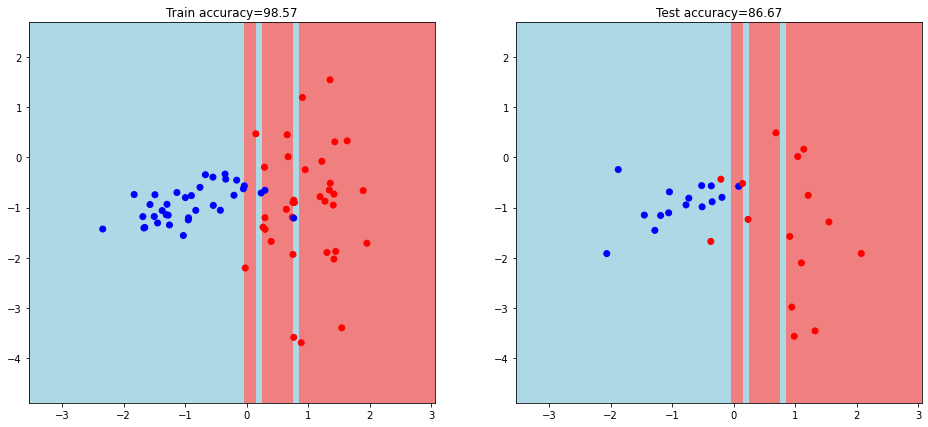

In [201]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.1, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_10,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [202]:
# лес из пятидесяти деревьев

n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 86.667


(5159, 0) (5159, 1) (5159, 1)


Text(0.5, 1.0, 'Test accuracy=86.67')

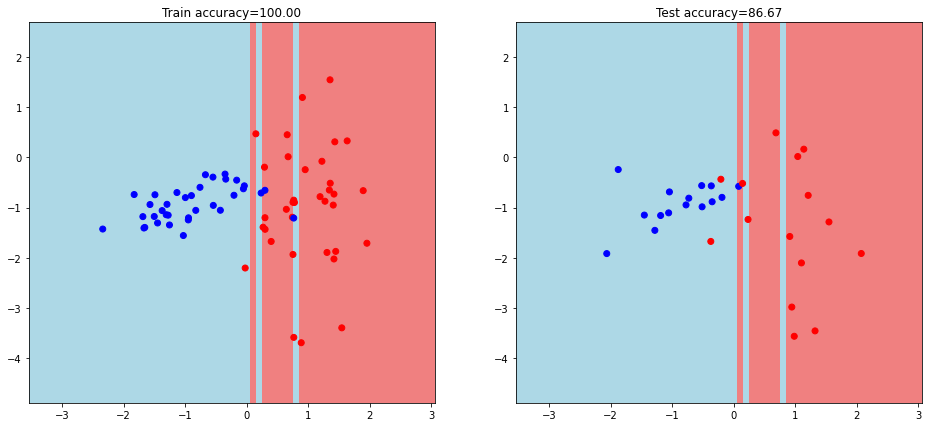

In [203]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.1, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forest_50,gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

По теории сложность гиперплоскости уменьшается при увеличении числа деревьев, однако у меня на графиках сложность одинаковая. При малом количестве деревьев в лесу наблюдается переобучение случайного леса. Начиная с 10 деревьев, точность случайного леса перестает увеличиваться.

3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Не успеваю сделать, много работы - может, попозже доделаю как разгребусь немного, задание интересное - добавлю на гитхабе